# Light Field Pipeline

Verify each module works correctly.


## Imports

In [18]:
# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Project modules
from src.lightfield_io import load_hci_lightfield
from src.lightfield_shearing import refocus_shear_single
from src.tensor_extraction import (
    extract_horizontal_epi, extract_vertical_epi,
    extract_all_horizontal_epis, extract_all_vertical_epis
)

## Constants

In [19]:
# Scene path
SCENE_PATH = "data/training/boxes"

# Shear parameter (example alpha)
ALPHA = 1.2

# Angular indices for checks
U_CENTER = 4
V_CENTER = 4

# Spatial row/column for EPI extraction
Y_ROW = 128  # example row
X_COL = 128  # example column


## Helper Functions

In [25]:
def show_image(img, title=None, cmap=None):
    """
    Display a single image (H x W x C or H x W)
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

## 1. Input LF

Light field shape: (512, 512, 9, 9, 3)
Value range: 0.0 - 1.0


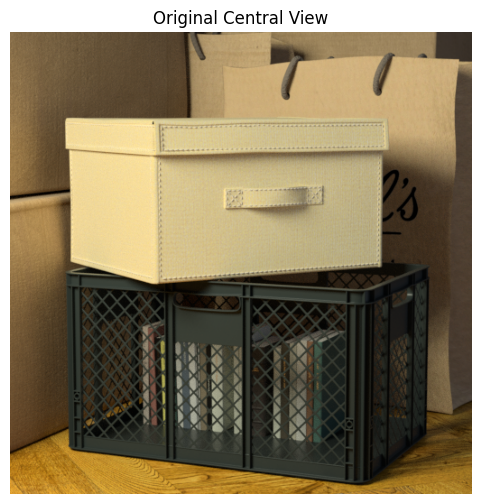

In [26]:
# Load light field
lf = load_hci_lightfield(SCENE_PATH)
print("Light field shape:", lf.shape)
print("Value range:", lf.min(), "-", lf.max())

# Visual check: central view
show_image(lf[:, :, U_CENTER, V_CENTER, :], title="Original Central View")

## 2. Light Field Shearing

Sheared LF shape: (512, 512, 9, 9, 3)


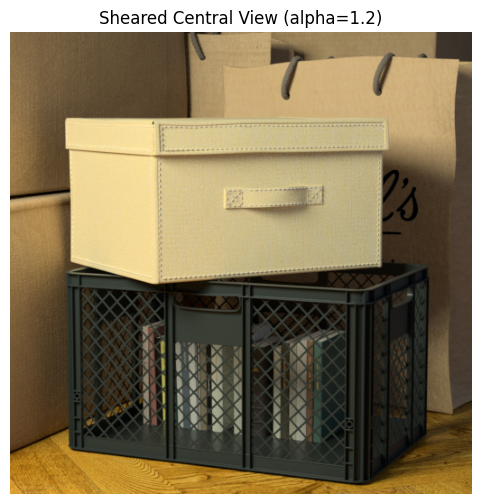

In [27]:
# Apply angular shear
sheared_lf = refocus_shear_single(lf, ALPHA)
print("Sheared LF shape:", sheared_lf.shape)

# Visual check: central view after shearing
show_image(sheared_lf[:, :, U_CENTER, V_CENTER, :], 
           title=f"Sheared Central View (alpha={ALPHA})")

## 3. Tensor Extraction

### 3.1 Single EPI Extraction

Horizontal EPI shape: (512, 9, 3)
Vertical EPI shape: (512, 9, 3)


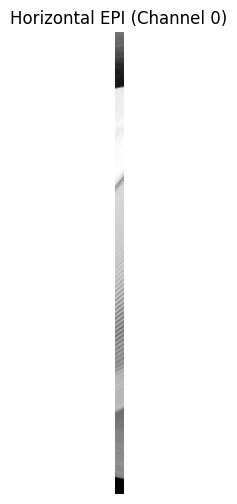

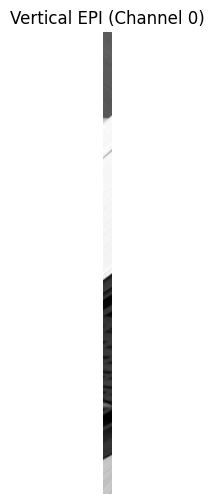

In [ ]:
# Extract single horizontal and vertical EPIs at chosen row/column
h_epi = extract_horizontal_epi(sheared_lf, Y_ROW, V_CENTER)
v_epi = extract_vertical_epi(sheared_lf, X_COL, U_CENTER)

print("Horizontal EPI shape:", h_epi.shape)  # (W, U, C)
print("Vertical EPI shape:", v_epi.shape)    # (H, V, C)

# Visual check: horizontal EPI (first channel)
show_image(h_epi[:, :, 0], cmap="gray", title="Horizontal EPI (Channel 0)")

# Visual check: vertical EPI (first channel)
show_image(v_epi[:, :, 0], cmap="gray", title="Vertical EPI (Channel 0)")

### 3.2 Full EPI Stack Extraction

Number of horizontal EPIs: 512
Number of vertical EPIs: 512


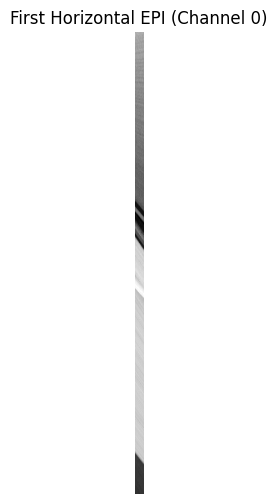

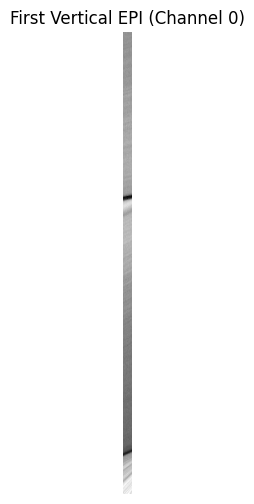

In [29]:
all_h_epis = extract_all_horizontal_epis(sheared_lf, V_CENTER)
all_v_epis = extract_all_vertical_epis(sheared_lf, U_CENTER)

print("Number of horizontal EPIs:", len(all_h_epis))  # Should match H
print("Number of vertical EPIs:", len(all_v_epis))    # Should match W

# Optional visual check: display first horizontal and vertical EPIs
show_image(all_h_epis[0][:, :, 0], cmap="gray", title="First Horizontal EPI (Channel 0)")
show_image(all_v_epis[0][:, :, 0], cmap="gray", title="First Vertical EPI (Channel 0)")